In [ ]:
# In einer Notebook-Zelle ausführen:
# !pip install neuralforecast yfinance pandas numpy matplotlib

In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST

# 1. Daten herunterladen
tickers = ['AAPL', 'SPY']
df_raw = yf.download(tickers, start="2020-01-01", end="2024-01-01")['Close']

# 2. Formatierung für NeuralForecast (erfordert Spalten: ds, y, unique_id)
# Wir schmelzen das DataFrame, um Multichannel-Daten zu simulieren
df = df_raw.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
df = df.rename(columns={'Date': 'ds'})



# Annahme: df_raw ist dein DataFrame mit den Schlusskursen (Close)
# Wir berechnen: log(P_t) - log(P_{t-1})
df_log = np.log(df_raw / df_raw.shift(1)).dropna()

# Umwandeln in das NeuralForecast Format (ds, unique_id, y)
df = df_log.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
df = df.rename(columns={'Date': 'ds'})
# Wichtig: NeuralForecast erwartet 'ds' als Datetime

df['ds'] = pd.to_datetime(df['ds'])

print("Vorschau Log-Returns (y sollte jetzt nahe 0 liegen):")
print(df.head())

[*********************100%***********************]  2 of 2 completed

Vorschau Log-Returns (y sollte jetzt nahe 0 liegen):
          ds unique_id         y
0 2020-01-03      AAPL -0.009769
1 2020-01-06      AAPL  0.007937
2 2020-01-07      AAPL -0.004714
3 2020-01-08      AAPL  0.015958
4 2020-01-09      AAPL  0.021019


In [10]:
from neuralforecast.models import PatchTST

# 1. Parameter-Definition
horizon = 7
input_size = 60

# 2. Modell-Initialisierung
# Wir nutzen hier nur die Kern-Argumente, die sicher akzeptiert werden.
model = PatchTST(
    h=horizon, 
    input_size=input_size,
    # Architektonische Parameter (Diese sollten eigentlich klappen, 
    # aber wir reduzieren sie aufs Wesentliche, falls deine Version zickt)
    patch_len=16,
    stride=8,
    # Hardware/Trainer Parameter
    max_steps=1000,
    batch_size=32,
    #accelerator='gpu',
    devices=1
)

# Falls du d_model und n_heads unbedingt setzen willst und es oben kracht,
# akzeptiert NeuralForecast diese oft eher als Standardwerte oder 
# innerhalb eines 'model_params' Dictionarys (je nach Version).

nf = NeuralForecast(models=[model], freq='B')

# 3. Fit ausführen
nf.fit(df=df)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.

  | Name         | Type              | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss         | MAE               | 0      | train | 0    
1 | padder_train | ConstantPad1d     | 0      | train | 0    
2 | scaler       | TemporalNorm      | 0      | train | 0    
3 | model        | PatchTST_backbone | 406 K  | train | 0    
-------------------------------------------------------------------
406 K     Trainable params
3         Non-trainable params
406 K     Total params
1.627     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode
0         Total Flops


/home/lun/projects/timeseries_transformer/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s, v_num=4, train_loss_step=0.00836, train_loss_epoch=0.00836]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s, v_num=4, train_loss_step=0.00836, train_loss_epoch=0.00836]


In [11]:
# Training starten
#nf.fit(df=df)

# Vorhersage generieren
fcst_df = nf.predict()

print(fcst_df.head())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/home/lun/projects/timeseries_transformer/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.24it/s]
  unique_id         ds  PatchTST
0      AAPL 2024-01-01 -0.003997
1      AAPL 2024-01-02  0.003076
2      AAPL 2024-01-03 -0.000385
3      AAPL 2024-01-04  0.003068
4      AAPL 2024-01-05 -0.000485


In [12]:
# Cross-Validation ausführen (wie zuvor)
cv_df = nf.cross_validation(df=df, n_windows=5, step_size=7)

# Metriken berechnen
from sklearn.metrics import mean_squared_error

def evaluate_finance_metrics(df_results):
    # MAE für Log-Returns (sollte sehr klein sein, z.B. 0.01 bis 0.02)
    mae = np.abs(df_results['y'] - df_results['PatchTST']).mean()
    
    # Hit Rate: Haben wir die Richtung korrekt vorhergesagt?
    # Wir vergleichen, ob das Vorzeichen (plus/minus) gleich ist
    actual_dir = np.sign(df_results['y'])
    pred_dir = np.sign(df_results['PatchTST'])
    hit_rate = (actual_dir == pred_dir).mean()
    
    print(f"--- Backtest Ergebnisse ---")
    print(f"MAE (Log-Returns): {mae:.6f}")
    print(f"Directional Accuracy (Hit Rate): {hit_rate:.2%}")

evaluate_finance_metrics(cv_df)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.

  | Name         | Type              | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss         | MAE               | 0      | train | 0    
1 | padder_train | ConstantPad1d     | 0      | train | 0    
2 | scaler       | TemporalNorm      | 0      | train | 0    
3 | model        | PatchTST_backbone | 406 K  | train | 0    
-------------------------------------------------------------------
406 K     Trainable params
3         Non-trainable params
406 K     Total params
1.627     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode
0         Total Flops


/home/lun/projects/timeseries_transformer/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s, v_num=6, train_loss_step=0.00639, train_loss_epoch=0.00639]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s, v_num=6, train_loss_step=0.00639, train_loss_epoch=0.00639]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/home/lun/projects/timeseries_transformer/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.36it/s]
--- Backtest Ergebnisse ---
MAE (Log-Returns): 0.005743
Directional Accuracy (Hit Rate): 65.71%


In [13]:
# 1. Vorhersage für die nächsten Tage generieren (Log-Returns)
fcst_df = nf.predict()

# 2. Den letzten echten Preis aus den Originaldaten holen
# (Wir nehmen df_raw von vor der Log-Transformation)
last_actual_prices = df_raw.iloc[-1]

# 3. Invertierung der Log-Returns in Preise
forecast_results = []

for ticker in fcst_df['unique_id'].unique():
    # Filter für den aktuellen Ticker
    ticker_fcst = fcst_df[fcst_df['unique_id'] == ticker].copy()
    
    # Kumulative Summe der Log-Returns bilden und exponentiell umwandeln
    # Das ergibt den Multiplikator für den Preis
    price_multiplier = np.exp(ticker_fcst['PatchTST'].cumsum())
    
    # Multiplizieren mit dem letzten bekannten Preis
    ticker_fcst['price_pred'] = last_actual_prices[ticker] * price_multiplier
    forecast_results.append(ticker_fcst)

full_forecast = pd.concat(forecast_results)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/home/lun/projects/timeseries_transformer/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


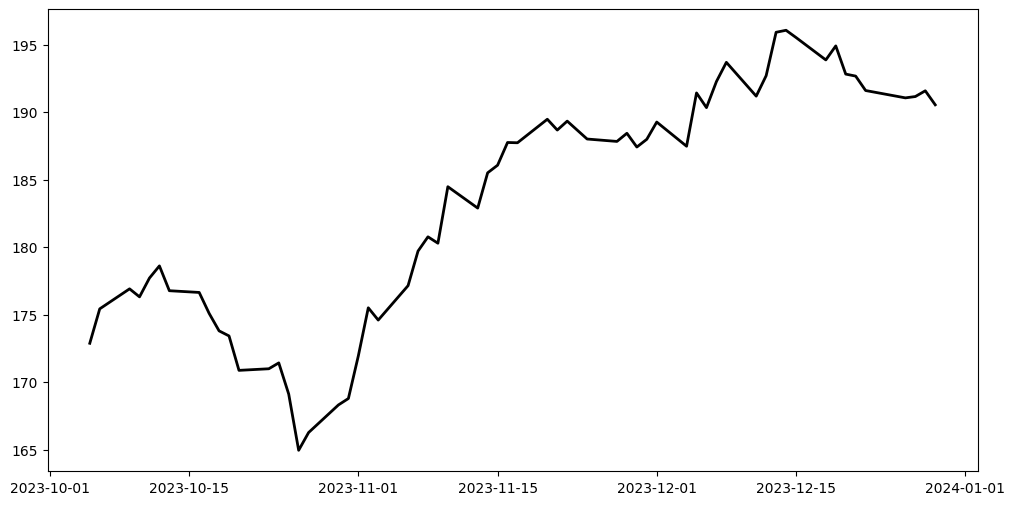

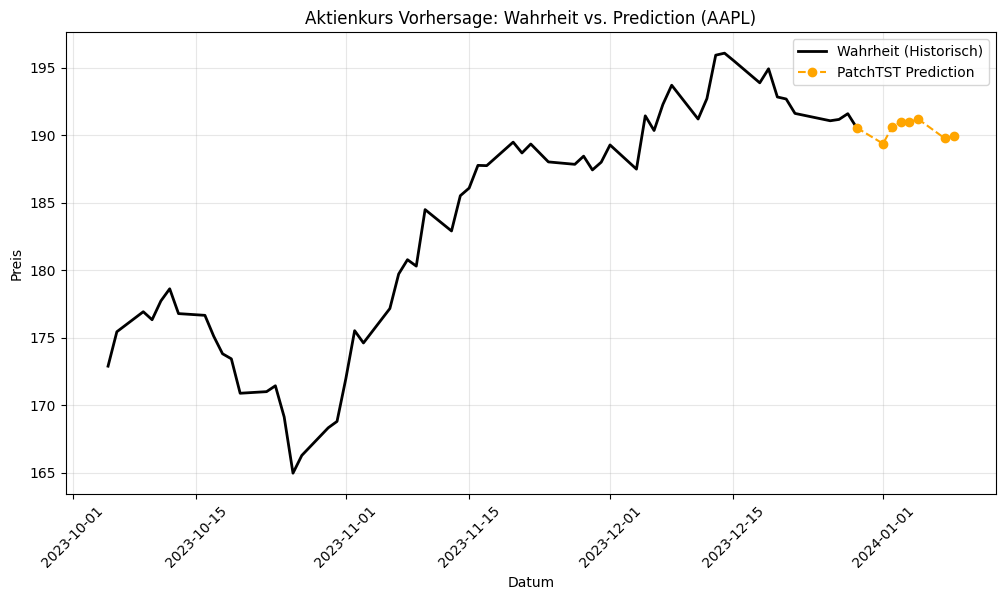

In [24]:
import matplotlib.pyplot as plt

ticker_to_plot = 'AAPL' # Oder ein anderer Ticker aus deinem Set

# Historische Daten (letzte 30 Tage)
historical = df_raw[ticker_to_plot].tail(60)
hist_dates = historical.index

# Vorhersage-Daten
prediction = full_forecast[full_forecast['unique_id'] == ticker_to_plot]
pred_dates = prediction['ds']
pred_values = prediction['price_pred']

plt.figure(figsize=(12, 6))

# Pfad der Wahrheit (Historie)

historical_p = df_raw[ticker_to_plot].tail(60)
plt.plot(historical_p.index, historical_p.values, label='Wahrheit (Historisch)', color='black', linewidth=2)

# Pfad der Prediction
# Wir verbinden den letzten historischen Punkt mit der ersten Prediction
# Wir konvertieren alles explizit in Series, um den TypeError zu vermeiden
full_dates = pd.concat([pd.Series(hist_dates[-1:]), pd.Series(pred_dates.values)])
full_values = pd.concat([pd.Series(historical.tail(1).values), pd.Series(pred_values.values)])

plt.figure(figsize=(12, 6))

# 1. Die historische Wahrheit
plt.plot(hist_dates, historical.values, label='Wahrheit (Historisch)', color='black', linewidth=2)

# 2. Die Vorhersage (verbunden mit dem letzten historischen Punkt)
plt.plot(full_dates, full_values, label='PatchTST Prediction', color='orange', linestyle='--', marker='o')

plt.title(f'Aktienkurs Vorhersage: Wahrheit vs. Prediction ({ticker_to_plot})')
plt.xlabel('Datum')
plt.ylabel('Preis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45) # Datum besser lesbar machen
plt.show()

In [25]:
#-------- Cross-validation ( compute prediction for each point )

# Wir führen die Cross-Validation über einen Zeitraum aus (z.B. die letzten 50 Tage)
# n_windows bestimmt, wie viele Vorhersage-Punkte wir generieren
cv_results = nf.cross_validation(df=df, n_windows=50, step_size=1)

# Filtern für deinen Ticker
ticker = 'AAPL'
cv_ticker = cv_results[cv_results['unique_id'] == ticker].copy()

# Jetzt kommt der entscheidende Teil: 
# Wir müssen die Log-Return-Vorhersage auf den Preis des JEWEILIGEN Vortags anwenden.
# Dafür holen wir uns die Originalpreise als Mapping-Basis.
price_lookup = df_raw[ticker]

def backtest_to_price(row):
    # Wir nehmen den Preis vom Tag VOR dem Datum 'ds'
    # 'ds' ist der Tag, für den vorhergesagt wurde
    vortag = row['ds'] - pd.Timedelta(days=1)
    
    # Suche den letzten verfügbaren Preis in den echten Daten vor diesem Datum
    # Wir nehmen den letzten Preis, der zeitlich vor der Prediction liegt
    last_price = price_lookup[:row['ds']].iloc[-2] # -2 weil -1 der Tag selbst ist
    
    # Invertiere den Log-Return
    return last_price * np.exp(row['PatchTST'])

cv_ticker['pred_price'] = cv_ticker.apply(backtest_to_price, axis=1)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.

  | Name         | Type              | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss         | MAE               | 0      | train | 0    
1 | padder_train | ConstantPad1d     | 0      | train | 0    
2 | scaler       | TemporalNorm      | 0      | train | 0    
3 | model        | PatchTST_backbone | 406 K  | train | 0    
-------------------------------------------------------------------
406 K     Trainable params
3         Non-trainable params
406 K     Total params
1.627     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode
0         Total Flops


/home/lun/projects/timeseries_transformer/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s, v_num=9, train_loss_step=0.00559, train_loss_epoch=0.00559]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s, v_num=9, train_loss_step=0.00559, train_loss_epoch=0.00559]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/home/lun/projects/timeseries_transformer/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.11it/s]


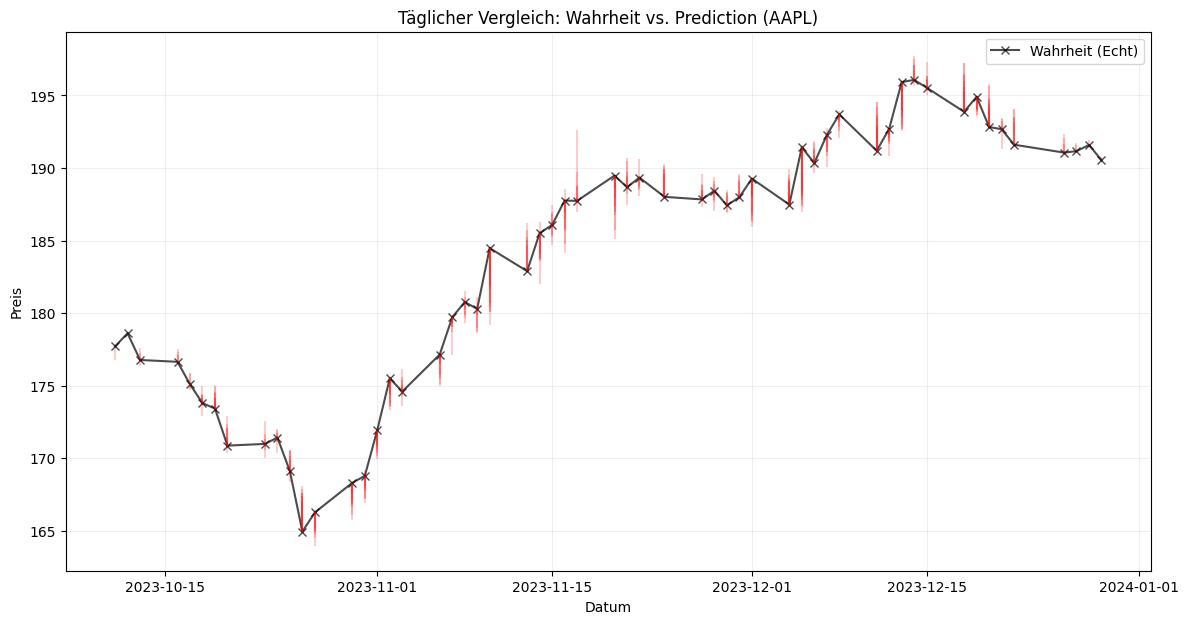

In [30]:
plt.figure(figsize=(14, 7))

# 1. Die "Wahrheit" (Echte Preise im Testzeitraum)
# Wir filtern die echten Daten auf den Zeitraum der Cross-Validation
plot_start = cv_ticker['ds'].min()
plot_end = cv_ticker['ds'].max()
truth = df_raw[ticker].loc[plot_start:plot_end]

plt.plot(truth.index, truth.values, label='Wahrheit (Echt)', color='black', linewidth=1.5, marker='x', alpha=0.7)

# 2. Die Vorhersagen (Jeweils 1-Schritt-Voraus Prognosen)
#plt.plot(cv_ticker['ds'], cv_ticker['pred_price'], label='PatchTST One-Step-Ahead', 
#         color='orange', linestyle='none', marker='o', markersize=4)

# 3. Verbindungslinien (Optional: zeigt den Fehler pro Tag)
for i, row in cv_ticker.iterrows():
    plt.vlines(x=row['ds'], ymin=min(row['y_true_price'] if 'y_true_price' in cv_ticker else truth.loc[row['ds']], row['pred_price']), 
               ymax=max(truth.loc[row['ds']], row['pred_price']), color='red', alpha=0.2)

plt.title(f'Täglicher Vergleich: Wahrheit vs. Prediction ({ticker})')
plt.xlabel('Datum')
plt.ylabel('Preis')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

In [ ]:
### trading simul
# 1. Wir nutzen die Ergebnisse aus der Cross-Validation
# cv_ticker enthält die Spalten 'y' (echte Returns) und 'PatchTST' (vorhergesagte Returns)
# Wir nehmen aus jedem Vorhersage-Fenster nur den ersten Tag (Cutoff + 1)
# Das verhindert das "Zurückspringen" der Linien
cv_ticker_clean = cv_ticker.groupby('cutoff').first().reset_index()

# Jetzt die Simulation mit dem sauberen DataFrame wiederholen
cv_ticker_clean['signal'] = (cv_ticker_clean['PatchTST'] > 0).astype(int)
cv_ticker_clean['strategy_returns'] = cv_ticker_clean['signal'] * cv_ticker_clean['y']

# Kumulative Werte
cv_ticker_clean['cum_strategy'] = cv_ticker_clean['strategy_returns'].cumsum().apply(np.exp)
cv_ticker_clean['cum_buy_hold'] = cv_ticker_clean['y'].cumsum().apply(np.exp)

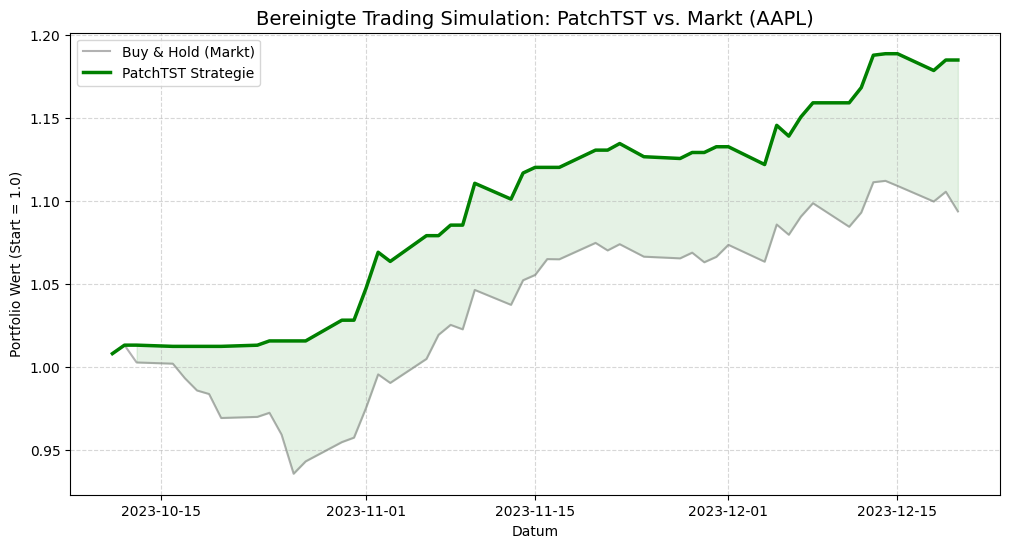

Endwert Strategie: 1.18
Endwert Buy & Hold: 1.09
Outperformance: 9.12 Prozentpunkte


In [39]:
plt.figure(figsize=(12, 6))

# Marktrendite (Grau)
plt.plot(cv_ticker_clean['ds'], cv_ticker_clean['cum_buy_hold'], 
         label='Buy & Hold (Markt)', color='gray', alpha=0.6, linewidth=1.5)

# PatchTST Strategie (Grün)
plt.plot(cv_ticker_clean['ds'], cv_ticker_clean['cum_strategy'], 
         label='PatchTST Strategie', color='green', linewidth=2.5)

# Optische Hervorhebung der Outperformance
plt.fill_between(cv_ticker_clean['ds'], 
                 cv_ticker_clean['cum_buy_hold'], 
                 cv_ticker_clean['cum_strategy'], 
                 where=(cv_ticker_clean['cum_strategy'] > cv_ticker_clean['cum_buy_hold']),
                 color='green', alpha=0.1)

plt.title(f'Bereinigte Trading Simulation: PatchTST vs. Markt ({ticker})', fontsize=14)
plt.xlabel('Datum')
plt.ylabel('Portfolio Wert (Start = 1.0)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

# Performance-Check
final_strat = cv_ticker_clean['cum_strategy'].iloc[-1]
final_bh = cv_ticker_clean['cum_buy_hold'].iloc[-1]
print(f"Endwert Strategie: {final_strat:.2f}")
print(f"Endwert Buy & Hold: {final_bh:.2f}")
print(f"Outperformance: {(final_strat - final_bh)*100:.2f} Prozentpunkte")

In [40]:
## test and train separation 
# Wir nehmen an, dein 'df' enthält Daten von 2020 bis 2024
train_df = df[df['ds'] < '2023-01-01']
test_df = df[df['ds'] >= '2023-01-01']

print(f"Trainings-Daten bis: {train_df['ds'].max()}")
print(f"Test-Daten ab: {test_df['ds'].min()}")

Trainings-Daten bis: 2022-12-30 00:00:00
Test-Daten ab: 2023-01-03 00:00:00


In [42]:
model_clean = PatchTST(
    h=7, 
    input_size=60,
    max_steps=1000,
    batch_size=32,
    #accelerator='gpu',
    devices=1
)

nf_clean = NeuralForecast(models=[model_clean], freq='B')

# WICHTIG: Nur mit dem Trainings-Set fitten!
nf_clean.fit(df=train_df)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.

  | Name         | Type              | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss         | MAE               | 0      | train | 0    
1 | padder_train | ConstantPad1d     | 0      | train | 0    
2 | scaler       | TemporalNorm      | 0      | train | 0    
3 | model        | PatchTST_backbone | 406 K  | train | 0    
-------------------------------------------------------------------
406 K     Trainable params
3         Non-trainable params
406 K     Total params
1.627     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode
0         Total Flops


/home/lun/projects/timeseries_transformer/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, v_num=11, train_loss_step=0.00792, train_loss_epoch=0.00792]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, v_num=11, train_loss_step=0.00792, train_loss_epoch=0.00792]


In [ ]:
# Wir nutzen die Cross-Validation auf dem Test-Set, um rollierende Vorhersagen zu erhalten
# n_windows deckt hier das Jahr 2023 ab
cv_test = nf_clean.cross_validation(df=test_df, n_windows=100, step_size=1)


In [56]:

# Daten wieder bereinigen (Zick-Zack-Fix)
cv_test_clean = cv_test.groupby('cutoff').first().reset_index()

# Trading-Logik anwenden
cv_test_clean['signal'] = (cv_test_clean['PatchTST'] > 0).astype(int)
cv_test_clean['strategy_returns'] = cv_test_clean['signal'] * cv_test_clean['y']
cv_test_clean['cum_strategy_long_only'] = cv_test_clean['strategy_returns'].cumsum().apply(np.exp)
cv_test_clean['cum_buy_hold'] = cv_test_clean['y'].cumsum().apply(np.exp)

# Signal: 1 bei positivem Return, -1 bei negativem Return
cv_test_clean['signal'] = np.where(cv_test_clean['PatchTST'] > 0, 1, -1)

# Geh nur Short, wenn der erwartete Verlust größer als -0.5% ist
threshold = -0.005 

cv_test_clean['signal'] = 0
cv_test_clean.loc[cv_test_clean['PatchTST'] > 0, 'signal'] = 1
cv_test_clean.loc[cv_test_clean['PatchTST'] < threshold, 'signal'] = -1

# Strategie-Rendite: 
# Wenn Signal -1 und der echte Return (y) negativ ist, 
# ergibt (-1 * -y) ein Plus -> Profit durch Shorting!
cv_test_clean['strategy_returns'] = cv_test_clean['signal'] * cv_test_clean['y']

# Kumulative Performance neu berechnen
cv_test_clean['cum_strategy_long_short'] = cv_test_clean['strategy_returns'].cumsum().apply(np.exp)

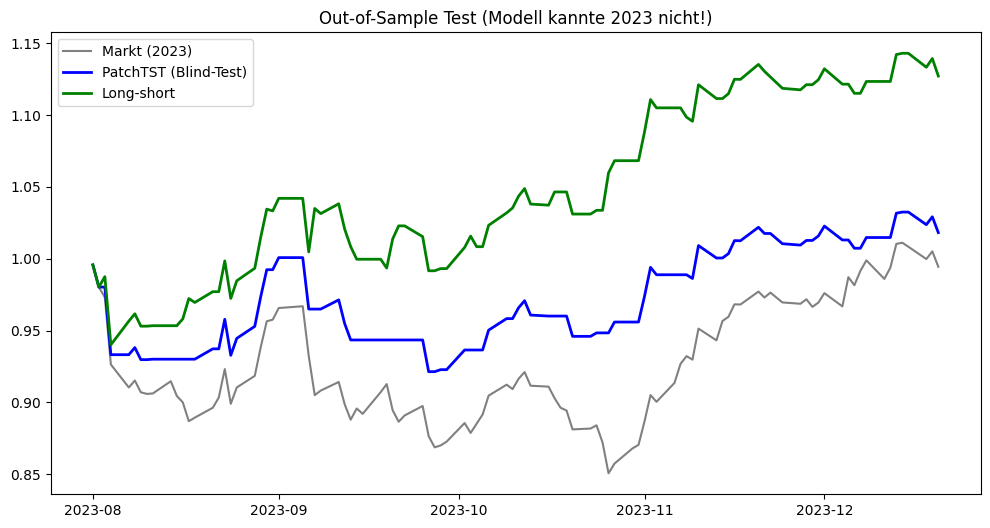

Endwert cum_strategy_long_only: 1.0182
Endwert Buy & Hold: 0.9944
Endwert Long/short: 1.1272
Outperformance: 2.38 Prozentpunkte


In [57]:
plt.figure(figsize=(12, 6))
plt.plot(cv_test_clean['ds'], cv_test_clean['cum_buy_hold'], label='Markt (2023)', color='gray')
plt.plot(cv_test_clean['ds'], cv_test_clean['cum_strategy_long_only'], label='PatchTST (Blind-Test)', color='blue', linewidth=2)

plt.plot(cv_test_clean['ds'], cv_test_clean['cum_strategy_long_short'], label='Long-short', color='green', linewidth=2)


plt.title('Out-of-Sample Test (Modell kannte 2023 nicht!)')
plt.legend()
plt.show()

# Performance-Metriken
final_strat = cv_test_clean['cum_strategy_long_only'].iloc[-1]
final_bh = cv_test_clean['cum_buy_hold'].iloc[-1]
final_shortlong = cv_test_clean['cum_strategy_long_short'].iloc[-1]
print(f"Endwert cum_strategy_long_only: {final_strat:.4f}")
print(f"Endwert Buy & Hold: {final_bh:.4f}")
print(f"Endwert Long/short: {final_shortlong:.4f}")
print(f"Outperformance: {(final_strat - final_bh)*100:.2f} Prozentpunkte")

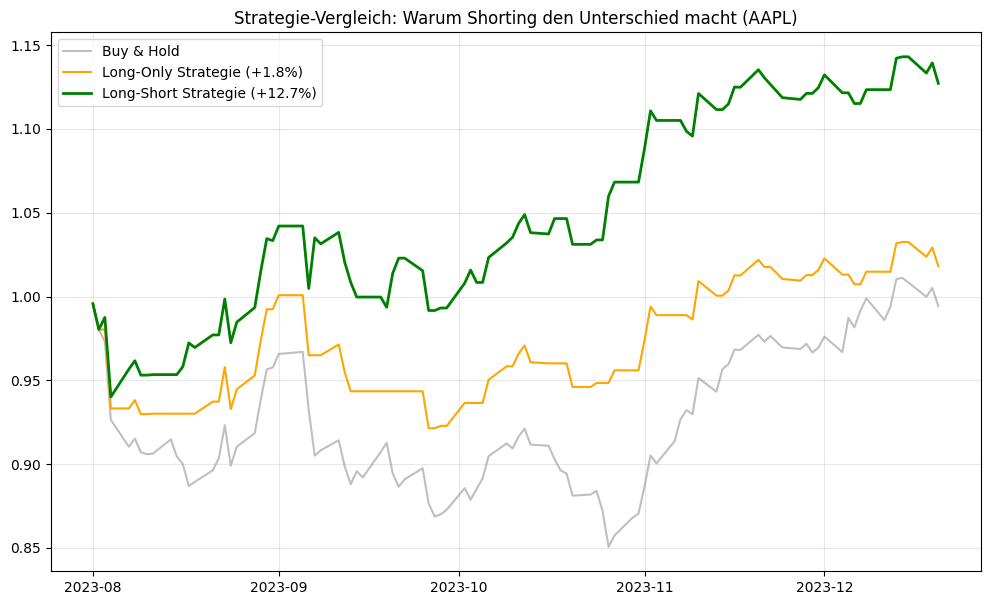

In [58]:
plt.figure(figsize=(12, 7))

# 1. Benchmark
plt.plot(cv_test_clean['ds'], cv_test_clean['cum_buy_hold'], 
         label='Buy & Hold', color='gray', alpha=0.5)

# 2. Deine erste Strategie (nur Long oder Cash)
# (Hierfür müsstest du die cum_strategy_long_only kurz berechnen)
plt.plot(cv_test_clean['ds'], cv_test_clean['cum_strategy_long_only'], 
         label='Long-Only Strategie (+1.8%)', color='orange')

# 3. Die neue Long-Short Strategie
plt.plot(cv_test_clean['ds'], cv_test_clean['cum_strategy_long_short'], 
         label='Long-Short Strategie (+12.7%)', color='green', linewidth=2)

plt.title(f'Strategie-Vergleich: Warum Shorting den Unterschied macht ({ticker})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [62]:
# 1. Definieren eines Schwellenwerts (z.B. 0,5% erwartete Bewegung)
# Alles zwischen -0.005 und 0.005 ignorieren wir (bleiben in Cash oder halten)
threshold = 0.008 

cv_test_clean['signal_robust'] = 0
cv_test_clean.loc[cv_test_clean['PatchTST'] > threshold, 'signal_robust'] = 1
cv_test_clean.loc[cv_test_clean['PatchTST'] < -threshold, 'signal_robust'] = -1

# 2. Performance berechnen
cv_test_clean['strategy_robust_returns'] = cv_test_clean['signal_robust'] * cv_test_clean['y']
cv_test_clean['cum_strategy_robust'] = cv_test_clean['strategy_robust_returns'].cumsum().apply(np.exp)

print(f"Anzahl Trades (Standard): {(cv_test_clean['signal'] != cv_test_clean['signal'].shift()).sum()}")
print(f"Anzahl Trades (Robust): {(cv_test_clean['signal_robust'] != cv_test_clean['signal_robust'].shift()).sum()}")

Anzahl Trades (Standard): 60
Anzahl Trades (Robust): 28


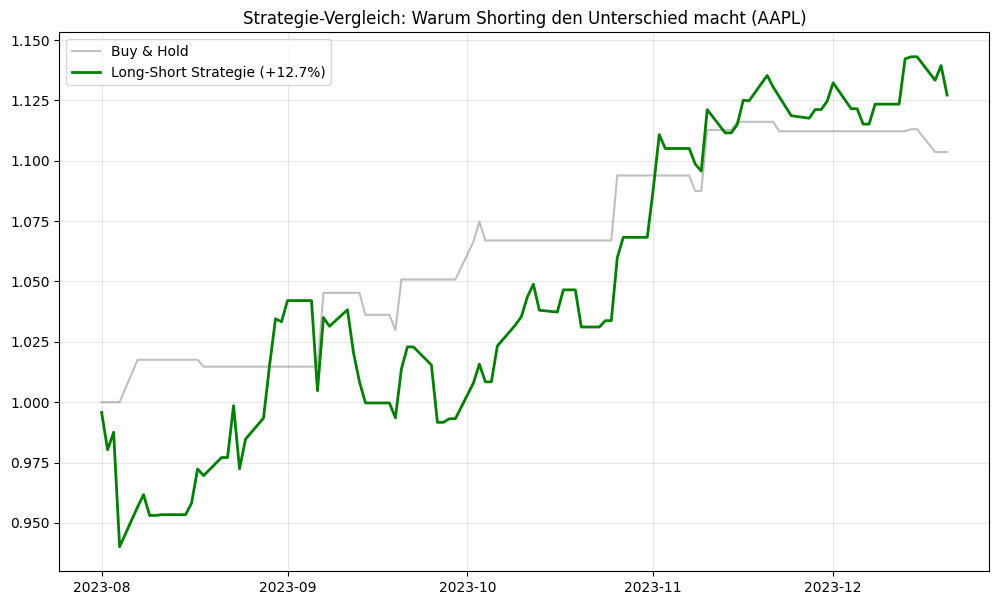

In [63]:
plt.figure(figsize=(12, 7))

# 1. Benchmark
plt.plot(cv_test_clean['ds'], cv_test_clean['cum_strategy_robust'], 
         label='Buy & Hold', color='gray', alpha=0.5)

# 3. Die neue Long-Short Strategie
plt.plot(cv_test_clean['ds'], cv_test_clean['cum_strategy_long_short'], 
         label='Long-Short Strategie (+12.7%)', color='green', linewidth=2)

plt.title(f'Strategie-Vergleich: Warum Shorting den Unterschied macht ({ticker})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()